In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mu_0 = 4e-7 * np.pi

R_p = 2.02
R_s = 2164.6
n_p = 400
n_s = 500
L_p = 4.6e-2
C = 486.63e-9
R_shunt = 993.5e3

d_air = 5.5e-3
A_air = np.pi * (d_air / 2) ** 2
width_iron = 4.32e-3
thickness_iron = 0.72e-3
A_iron = width_iron * thickness_iron
d_steel = 3.15e-3
A_steel = np.pi * (d_steel / 2) ** 2
d_cuni = 5e-3
A_cuni = np.pi * (d_cuni / 2) ** 2

In [3]:
# Calculate experimental relative variances for all variables
R_p_rel_var = (0.05 / R_p) ** 2
R_s_rel_var = (1 / R_s) ** 2
n_p_rel_var = (1 / n_p) ** 2
n_s_rel_var = (1 / n_s) ** 2
L_p_rel_var = (0.1e-2 / L_p) ** 2 
C_rel_var = (0.01e-9 / C) ** 2
R_shunt_rel_var = (0.1e3 / R_shunt) ** 2
A_air_rel_var = 4 * (0.02e-3 / d_air) ** 2
A_iron_rel_var = (0.02e-3 / width_iron) ** 2 + (0.02e-3/ thickness_iron) ** 2
A_steel_rel_var = 4 * (0.02e-3 / d_steel) ** 2
A_cuni_rel_var = 4 * (0.02e-3 / d_cuni) ** 2

In [4]:
def get_data(path, area):
  df = pd.read_csv(path)
  time = df['Time_ms'].to_numpy()
  H = df['Vx_V'].to_numpy() * n_p / (L_p * R_p)
  B = df['Vy_V'].to_numpy() * R_s * C / (n_s * area)
  return time, H, B

In [30]:
# Import raw data
air_time, air_H, air_B = get_data('raw_data/air.csv', A_air)
air_B -= air_B.mean() # Remove DC offset because measurement was made without AC coupling
steel_time, steel_H, steel_B = get_data('raw_data/steel.csv', A_steel)
iron_time, iron_H, iron_B = get_data('raw_data/iron.csv', A_iron)
cuni_cold_time, cuni_cold_H, cuni_cold_B = get_data('raw_data/cuni_cold.csv', A_cuni)
cuni_warm_time, cuni_warm_H, cuni_warm_B = get_data('raw_data/cuni_warm.csv', A_cuni)

# Calculate relative variances in H and B due to the uncertainties in component values
H_rel_var = n_p_rel_var + L_p_rel_var + R_p_rel_var
air_B_rel_var = R_s_rel_var + C_rel_var + n_s_rel_var + A_air_rel_var
iron_B_rel_var = R_s_rel_var + C_rel_var + n_s_rel_var + A_iron_rel_var
steel_B_rel_var = R_s_rel_var + C_rel_var + n_s_rel_var + A_steel_rel_var
cuni_B_rel_var = R_s_rel_var + C_rel_var + n_s_rel_var + A_cuni_rel_var

data_calibrated = False

In [31]:
# Find mu_r_air and error from linear regression
p, cov = np.polyfit(air_H, air_B, 1, cov=True)
mu_air = p[0]
mu_air_rel_var = cov[0, 0] + H_rel_var + air_B_rel_var
mu_r_air = mu_air / mu_0
print(f'Measured mu_r_air: {mu_r_air:.2f} ± {mu_r_air * np.sqrt(mu_air_rel_var):.2f}')

# Calibrate B values using the expected value for mu_r_air
if not data_calibrated:
  calibration = 1 / mu_r_air
  steel_B *= calibration
  air_B *= calibration
  iron_B *= calibration
  cuni_cold_B *= calibration
  cuni_warm_B *= calibration

  steel_B_rel_var += mu_air_rel_var
  air_B_rel_var += mu_air_rel_var
  iron_B_rel_var += mu_air_rel_var
  cuni_B_rel_var += mu_air_rel_var
  
  data_calibrated = True

Measured mu_r_air: 1.40 ± 0.05


In [29]:
# Find mu_r for warm cuni
p, cov = np.polyfit(cuni_warm_H, cuni_warm_B, 1, cov=True)
mu_cuni_warm = p[0]
mu_cuni_warm_rel_var = cov[0,0] + H_rel_var + cuni_B_rel_var
mu_r_cuni_warm = mu_cuni_warm / mu_0
print(f'Measured mu_r_cuni_warm: {mu_r_cuni_warm:.2f} ± {mu_r_cuni_warm * np.sqrt(mu_cuni_warm_rel_var):.2f}')


Measured mu_r_cuni_warm: 1.27 ± 0.06


In [12]:
# Split the hysteresis curve into rising H and falling H parts
def split_curve(t, H, B):
  # Create filtering kernel
  sigma = 50
  x = np.arange(-2*sigma, 2*sigma+1)
  kernel = np.exp(-x**2 / sigma**2) # Gaussian
  kernel /= kernel.sum() # Normalize kernel

  filtered_H = np.convolve(H, kernel, mode='same')
  mask = np.diff(filtered_H) > 0

  rising_t = t[1:][mask]
  rising_H = H[1:][mask]
  rising_B = B[1:][mask]
  falling_t = t[1:][~mask]
  falling_H = H[1:][~mask]
  falling_B = B[1:][~mask]

  return rising_t, rising_H, rising_B, falling_t, falling_H, falling_B

In [13]:
steel_rising_t, steel_rising_H, steel_rising_B, steel_falling_t, steel_falling_H, steel_falling_B = split_curve(steel_time, steel_H, steel_B)
air_rising_t, air_rising_H, air_rising_B, air_falling_t, air_falling_H, air_falling_B = split_curve(air_time, air_H, air_B)
iron_rising_t, iron_rising_H, iron_rising_B, iron_falling_t, iron_falling_H, iron_falling_B = split_curve(iron_time, iron_H, iron_B)
cuni_cold_rising_t, cuni_cold_rising_H, cuni_cold_rising_B, cuni_cold_falling_t, cuni_cold_falling_H, cuni_cold_falling_B = split_curve(cuni_cold_time, cuni_cold_H, cuni_cold_B)
cuni_warm_rising_t, cuni_warm_rising_H, cuni_warm_rising_B, cuni_warm_falling_t, cuni_warm_falling_H, cuni_warm_falling_B = split_curve(cuni_warm_time, cuni_warm_H, cuni_warm_B)

In [14]:
from numpy.random import default_rng
rng = default_rng()

def get_distributions(rising_H, rising_B, falling_H, falling_B):
  H_uniqs = np.intersect1d(rising_H, falling_H)
  rising_Bs_dist = []
  falling_Bs_dist = []
  for H_uniq in H_uniqs:
    rising_Bs_dist.append(rising_B[rising_H == H_uniq])
    falling_Bs_dist.append(falling_B[falling_H == H_uniq])
  return H_uniqs, rising_Bs_dist, falling_Bs_dist

In [15]:
steel_H_uniqs, steel_rising_B_dist, steel_falling_B_dist = get_distributions(steel_rising_H, steel_rising_B, steel_falling_H, steel_falling_B)
iron_H_uniqs, iron_rising_B_dist, iron_falling_B_dist = get_distributions(iron_rising_H, iron_rising_B, iron_falling_H, iron_falling_B)
cuni_cold_H_uniqs, cuni_cold_rising_B_dist, cuni_cold_falling_B_dist = get_distributions(cuni_cold_rising_H, cuni_cold_rising_B, cuni_cold_falling_H, cuni_cold_falling_B)

In [16]:
def get_mean_curve(rising_B_dist, falling_B_dist):
  num_vals = len(rising_B_dist)
  rising_B_means = np.empty(num_vals)
  rising_B_rel_vars = np.empty(num_vals)
  falling_B_means = np.empty(num_vals)
  falling_B_rel_vars = np.empty(num_vals)
  for i in range(num_vals):
    rising_B_means[i] = rising_B_dist[i].mean()
    rising_B_rel_vars[i] = rising_B_dist[i].var() / (rising_B_dist[i].mean() ** 2) / rising_B_dist[i].shape[0]
    falling_B_means[i] = falling_B_dist[i].mean()
    falling_B_rel_vars[i] = falling_B_dist[i].var() / (falling_B_dist[i].mean() ** 2) / falling_B_dist[i].shape[0]
  return rising_B_means, rising_B_rel_vars, falling_B_means, falling_B_rel_vars

In [17]:
steel_rising_B_means, steel_rising_B_rel_vars, steel_falling_B_means, steel_falling_B_rel_vars = get_mean_curve(steel_rising_B_dist, steel_falling_B_dist)
iron_rising_B_means, iron_rising_B_rel_vars, iron_falling_B_means, iron_falling_B_rel_vars = get_mean_curve(iron_rising_B_dist, iron_falling_B_dist)
cuni_cold_rising_B_means, cuni_cold_rising_B_rel_vars, cuni_cold_falling_B_means, cuni_cold_falling_B_rel_vars = get_mean_curve(cuni_cold_rising_B_dist, cuni_cold_falling_B_dist)

In [18]:
def get_mean_area(rising_B_means, rising_B_rel_vars, falling_B_means, falling_B_rel_vars, H_uniqs):
  rising_B_abs_vars = rising_B_rel_vars * (rising_B_means ** 2)
  falling_B_abs_vars = falling_B_rel_vars * (falling_B_means ** 2)

  B_differences = falling_B_means - rising_B_means
  B_differences_abs_vars = falling_B_abs_vars + rising_B_abs_vars

  area_mean = np.trapz(B_differences, H_uniqs)
  area_abs_var = B_differences_abs_vars.sum() / H_uniqs.shape[0]
  area_rel_var = area_abs_var / (area_mean ** 2)
  return area_mean, area_rel_var

In [19]:
steel_area_mean, steel_area_rel_var = get_mean_area(steel_rising_B_means, steel_rising_B_rel_vars, steel_falling_B_means, steel_falling_B_rel_vars, steel_H_uniqs)
iron_area_mean, iron_area_rel_var = get_mean_area(iron_rising_B_means, iron_rising_B_rel_vars, iron_falling_B_means, iron_falling_B_rel_vars, iron_H_uniqs)
cuni_cold_area_mean, cuni_cold_area_rel_var = get_mean_area(cuni_cold_rising_B_means, cuni_cold_rising_B_rel_vars, cuni_cold_falling_B_means, cuni_cold_falling_B_rel_vars, cuni_cold_H_uniqs)

In [20]:
steel_energy_mean = steel_area_mean
steel_energy_rel_var = steel_area_rel_var + steel_B_rel_var + H_rel_var
iron_energy_mean = iron_area_mean
iron_energy_rel_var = iron_area_rel_var + iron_B_rel_var + H_rel_var
cuni_cold_energy_mean = cuni_cold_area_mean
cuni_cold_energy_rel_var = cuni_cold_area_rel_var + cuni_B_rel_var + H_rel_var

In [50]:
print('Energy Dissipated per Cycle:\n'
      f'Steel: ({steel_energy_mean:.0f} ± {steel_energy_mean * np.sqrt(steel_energy_rel_var):.0f}) Jm^-3\n'
      f'Iron: ({iron_energy_mean:.0f} ± {iron_energy_mean * np.sqrt(iron_energy_rel_var):.0f}) Jm^-3\n'
      f'CuNi: ({cuni_cold_energy_mean:.0f} ± {cuni_cold_energy_mean * np.sqrt(cuni_cold_energy_rel_var):.0f}) Jm^-3')

Energy Dissipated per Cycle:
Steel: (24985 ± 1225) Jm^-3
Iron: (9244 ± 509) Jm^-3
CuNi: (213 ± 10.2) Jm^-3


In [22]:
frequency = 50
steel_power_mean = steel_area_mean * frequency
iron_power_mean = iron_area_mean * frequency
cuni_cold_power_mean = cuni_cold_area_mean * frequency

print('Power Dissipated:\n'
      f'Steel: ({steel_power_mean:.0f} ± {steel_power_mean * np.sqrt(steel_energy_rel_var):.0f}) Wm^-3\n'
      f'Iron: ({iron_power_mean:.0f} ± {iron_power_mean * np.sqrt(iron_energy_rel_var):.0f}) Wm^-3\n'
      f'CuNi: ({cuni_cold_power_mean:.0f} ± {cuni_cold_power_mean * np.sqrt(cuni_cold_energy_rel_var):.0f}) Wm^-3')

Power Dissipated:
Steel: (1249263 ± 61273) Wm^-3
Iron: (462224 ± 25474) Wm^-3
CuNi: (10656 ± 512) Wm^-3


In [23]:
def plot_density_repres(H, B, subsampling, point_size, ax):
  H_quant = np.diff(np.unique(H)).mean()
  B_quant = np.diff(np.unique(B)).mean()
  H_display = H[::subsampling] + np.random.uniform(-H_quant/2, H_quant/2, H[::subsampling].shape)
  B_display = B[::subsampling] + np.random.uniform(-B_quant/2, B_quant/2, B[::subsampling].shape)
  ax.scatter(H_display, B_display, s=point_size)

In [51]:
def plot_mu_graphs(rising_B_dist, falling_B_dist, H_uniqs, B_rel_var, H, B, sigma, subsampling, point_size, title):
  # Get means and variances
  num_vals = len(rising_B_dist)
  rising_B_means = np.empty(num_vals)
  falling_B_means = np.empty(num_vals)
  rising_B_abs_vars = np.empty(num_vals)
  falling_B_abs_vars = np.empty(num_vals)

  for i in range(num_vals):
    rising_B_means[i] = rising_B_dist[i].mean()
    falling_B_means[i] = falling_B_dist[i].mean()
    rising_B_abs_vars[i] = rising_B_dist[i].var() / rising_B_dist[i].shape[0]
    falling_B_abs_vars[i] = falling_B_dist[i].var() / falling_B_dist[i].shape[0]

  # Filter with Gaussian to remove noise
  x = np.arange(-2*sigma, 2*sigma+1)
  kernel = np.exp(-x**2 / sigma**2)
  kernel /= kernel.sum()
  filtered_rising_B_means = np.convolve(rising_B_means, kernel, mode='valid')
  filtered_falling_B_means = np.convolve(falling_B_means, kernel, mode='valid')
  filtered_rising_B_abs_vars = np.convolve(rising_B_abs_vars, kernel, mode='valid')
  filtered_falling_B_abs_vars = np.convolve(falling_B_abs_vars, kernel, mode='valid')

  # Crop H to fit with filtered B
  kernel_half_width = (x.shape[0] - 1) // 2
  H_cropped = H_uniqs[kernel_half_width:-kernel_half_width]

  # Plot filtered mean curve over point density representation of raw data to confirm filter is reasonable
  fig, axs = plt.subplots(ncols=3, figsize=(30,10), constrained_layout=True)
  fig.suptitle(title, fontsize=16)
  plot_density_repres(H, B, subsampling, point_size, axs[0])
  axs[0].plot(H_cropped, filtered_rising_B_means, '-r', lw=1)
  axs[0].plot(H_cropped, filtered_falling_B_means, '-r', lw=1)
  axs[0].set_xlabel(r'$H\;/(Am^{-1})$', fontsize=14)
  axs[0].set_ylabel(r'$B\;/T$', fontsize=14)
  axs[0].text(axs[0].get_xlim()[0]*0.95, axs[0].get_ylim()[1]*0.9, '(a)', fontsize=20)

  kernel = np.diff(kernel)

  # Calculate permeabilities and their variances
  rising_B_mus = np.convolve(rising_B_means, kernel, mode='valid')
  falling_B_mus = np.convolve(falling_B_means, kernel, mode='valid')
  rising_B_mu_abs_vars = np.convolve(rising_B_abs_vars, kernel**2, mode='valid') # Use squared kernel (for reason see report)
  falling_B_mu_abs_vars = np.convolve(falling_B_abs_vars, kernel**2, mode='valid')
  rising_B_mu_rel_vars = rising_B_mu_abs_vars / (rising_B_mus ** 2)
  falling_B_mu_rel_vars = falling_B_mu_abs_vars / (falling_B_mus ** 2)
  # Scale by H quantisation to obtain permeabilities
  H_quant = np.diff(H_uniqs).mean()
  rising_B_mus /= H_quant
  falling_B_mus /= H_quant

  # Add variances from components
  rising_B_mu_rel_vars += (B_rel_var + H_rel_var)
  falling_B_mu_rel_vars += (B_rel_var + H_rel_var)

  # Scale by mu_0 to obtain relative permeabilities
  rising_B_mu_rs = rising_B_mus / mu_0
  falling_B_mu_rs = falling_B_mus / mu_0
  rising_B_mu_r_abs_vars = rising_B_mu_rel_vars * (rising_B_mu_rs ** 2)
  falling_B_mu_r_abs_vars = falling_B_mu_rel_vars * (falling_B_mu_rs ** 2)

  # Get minimum and maximum mu_r values and their variances
  rising_B_mu_r_min_idx = np.argmin(rising_B_mu_rs)
  rising_B_mu_r_min = rising_B_mu_rs[rising_B_mu_r_min_idx]
  rising_B_mu_r_min_abs_var = rising_B_mu_r_abs_vars[rising_B_mu_r_min_idx]
  rising_B_mu_r_max_idx = np.argmax(rising_B_mu_rs)
  rising_B_mu_r_max = rising_B_mu_rs[rising_B_mu_r_max_idx]
  rising_B_mu_r_max_abs_var = rising_B_mu_r_abs_vars[rising_B_mu_r_max_idx]

  falling_B_mu_r_min_idx = np.argmin(falling_B_mu_rs)
  falling_B_mu_r_min = falling_B_mu_rs[falling_B_mu_r_min_idx]
  falling_B_mu_r_min_abs_var = falling_B_mu_r_abs_vars[falling_B_mu_r_min_idx]
  falling_B_mu_r_max_idx = np.argmax(falling_B_mu_rs)
  falling_B_mu_r_max = falling_B_mu_rs[falling_B_mu_r_max_idx]
  falling_B_mu_r_max_abs_var = falling_B_mu_r_abs_vars[falling_B_mu_r_max_idx]

  kernel_half_width = x.shape[0] // 2
  H_cropped = H_uniqs[kernel_half_width-1:-kernel_half_width]

  axs[1].errorbar(H_cropped, rising_B_mu_rs, fmt='-b', yerr=np.sqrt(rising_B_mu_r_abs_vars))
  axs[1].set_xlabel(r'$H\;/(Am^{-1})$', fontsize=14)
  axs[1].set_ylabel(r'$\mu_r$', fontsize=14)
  axs[1].text(-20000, axs[1].get_ylim()[1]*0.9,
              f'min. $\\mu_r = {rising_B_mu_r_min:.2f} \\pm {np.sqrt(rising_B_mu_r_min_abs_var):.2f}$\n'
              f'max. $\\mu_r = {rising_B_mu_r_max:.2f} \\pm {np.sqrt(rising_B_mu_r_max_abs_var):.2f}$', fontsize=14)
  axs[1].text(axs[1].get_xlim()[0]*0.95, axs[1].get_ylim()[1]*0.95, '(b)', fontsize=20)
  axs[2].errorbar(H_cropped, falling_B_mu_rs, fmt='-r', yerr=np.sqrt(falling_B_mu_r_abs_vars))
  axs[2].set_xlabel(r'$H\;/(Am^{-1})$', fontsize=14)
  axs[2].set_ylabel(r'$\mu_r$', fontsize=14)
  axs[2].text(10000, axs[2].get_ylim()[1]*0.9,
              f'min. $\\mu_r = {falling_B_mu_r_min:.2f} \\pm {np.sqrt(falling_B_mu_r_min_abs_var):.2f}$\n'
              f'max. $\\mu_r = {falling_B_mu_r_max:.2f} \\pm {np.sqrt(falling_B_mu_r_max_abs_var):.2f}$', fontsize=14)
  axs[2].text(axs[2].get_xlim()[0]*0.95, axs[2].get_ylim()[1]*0.95, '(c)', fontsize=20)

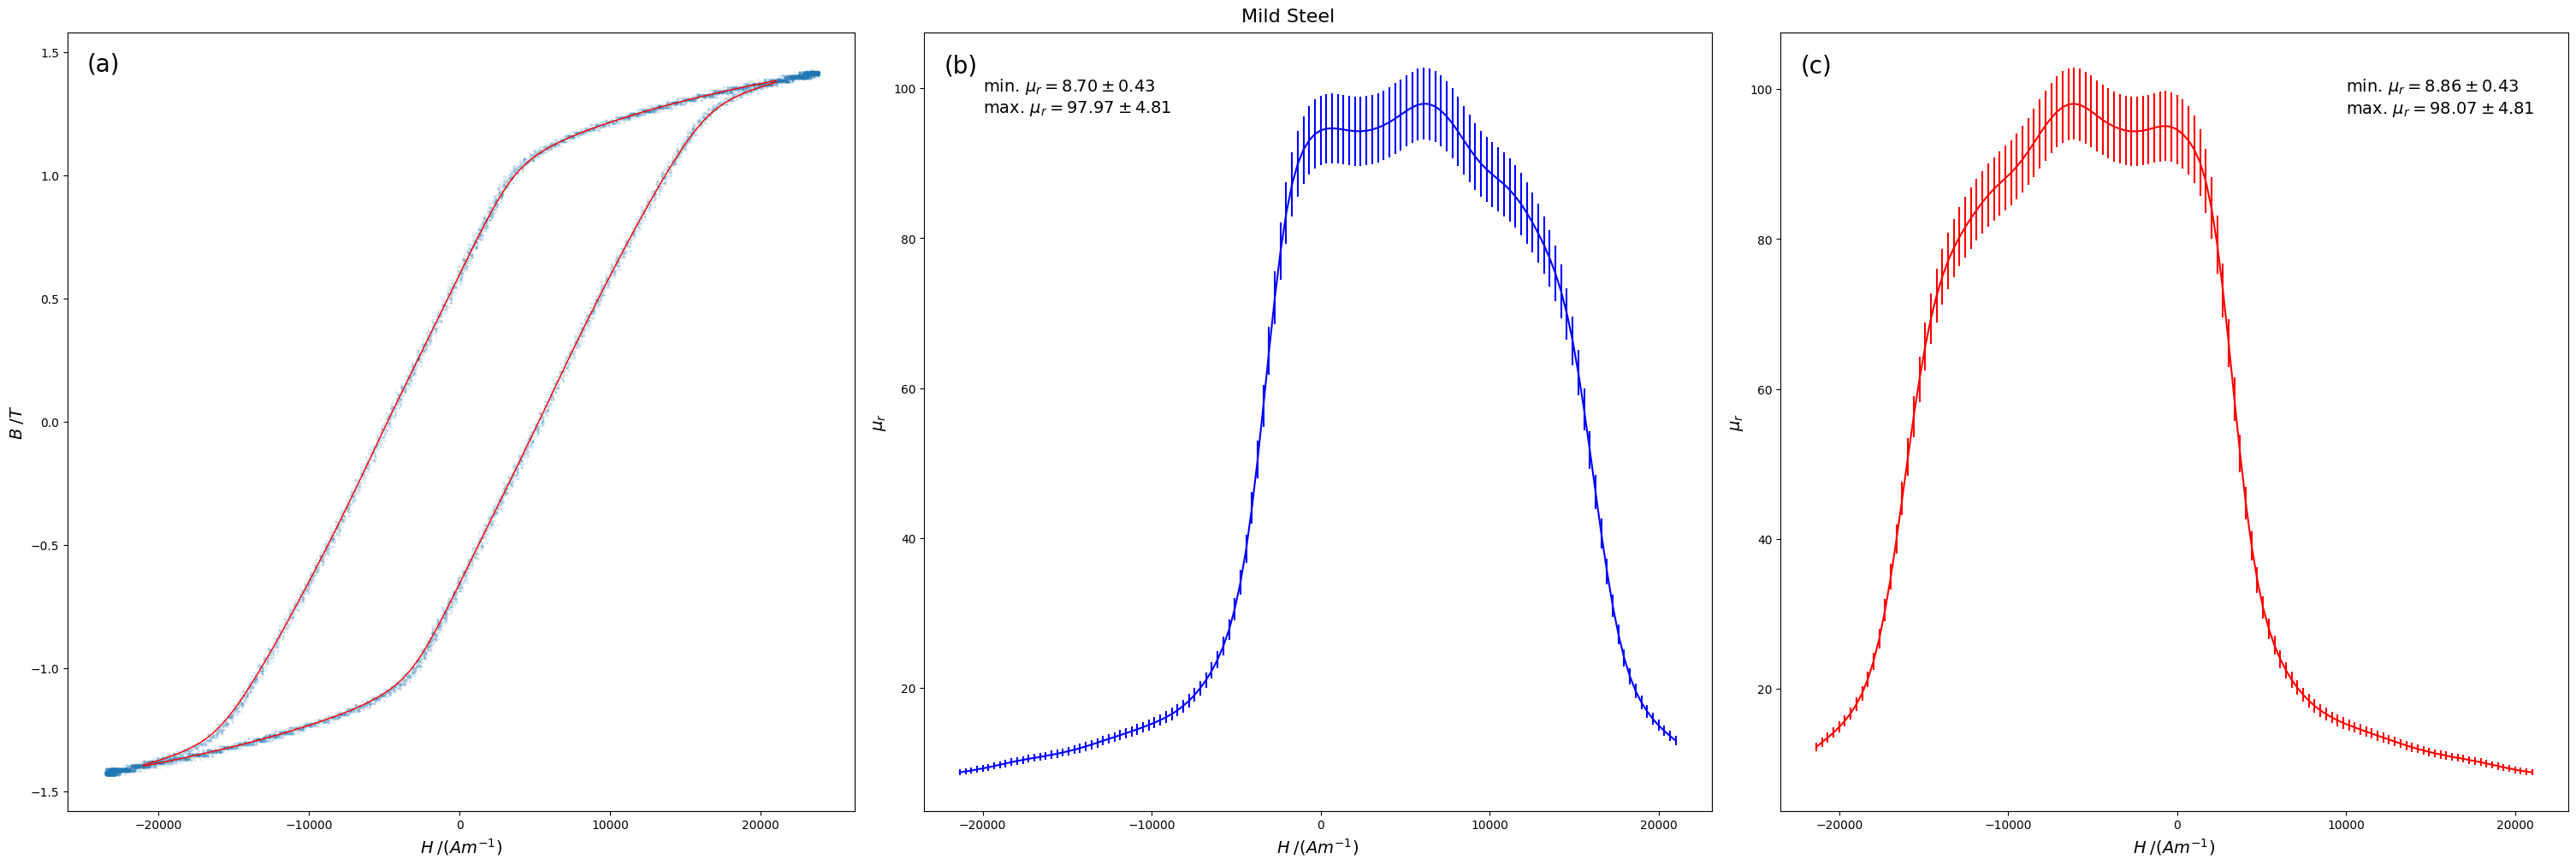

In [52]:
plot_mu_graphs(steel_rising_B_dist, steel_falling_B_dist, steel_H_uniqs, steel_B_rel_var, steel_H, steel_B, sigma=4, subsampling=100, point_size=0.01, title='Mild Steel')
plt.savefig('figures/steel_mu.png', dpi=300)

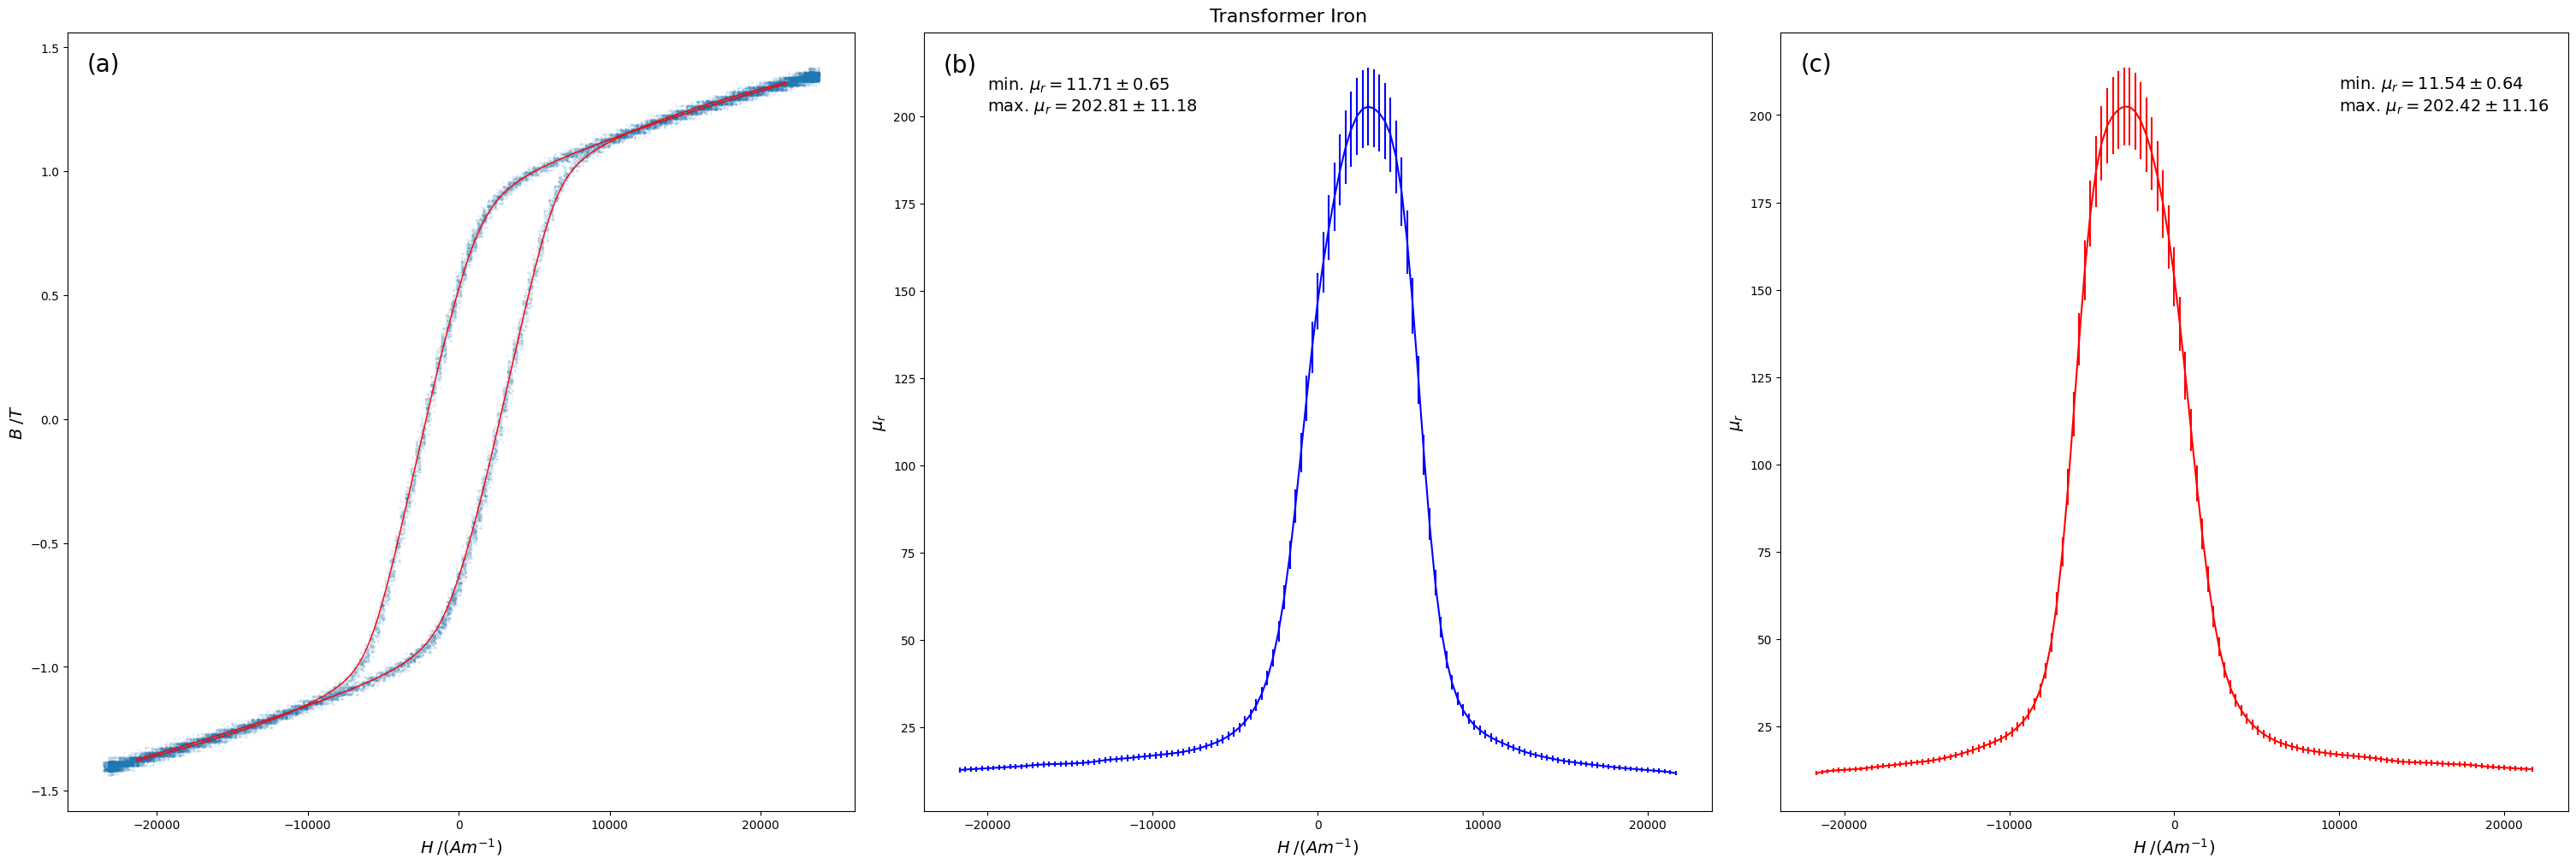

In [53]:
plot_mu_graphs(iron_rising_B_dist, iron_falling_B_dist, iron_H_uniqs, iron_B_rel_var, iron_H, iron_B, sigma=3, subsampling=50, point_size=0.01, title='Transformer Iron')
plt.savefig('figures/iron_mu.png', dpi=300)

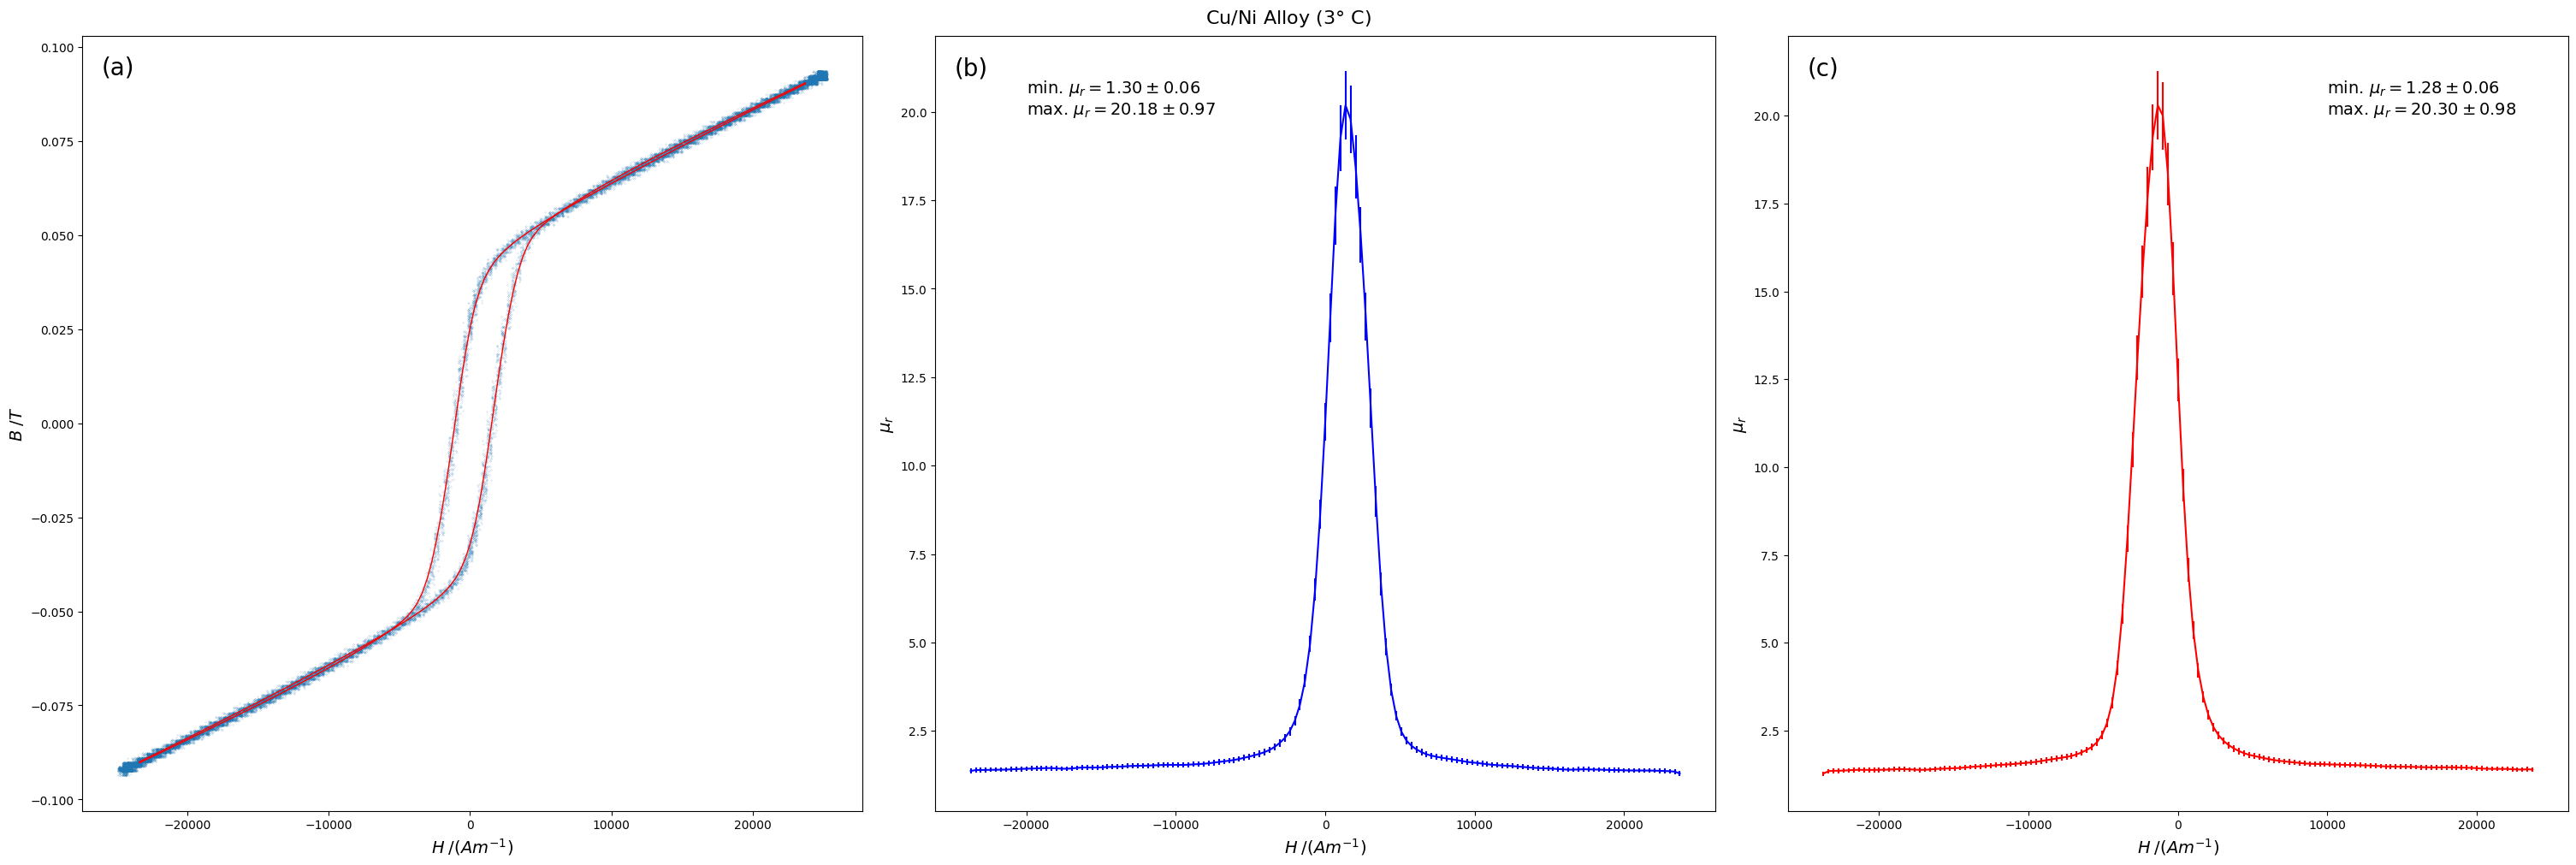

In [54]:
plot_mu_graphs(cuni_cold_rising_B_dist, cuni_cold_falling_B_dist, cuni_cold_H_uniqs, cuni_B_rel_var, cuni_cold_H, cuni_cold_B, sigma=2, subsampling=50, point_size=0.01, title='Cu/Ni Alloy (3$\degree$ C)')
plt.savefig('figures/cuni_cold_mu.png', dpi=300)

In [44]:
def plot_loops(H, B, subsampling, point_size, title):
  fig, axs = plt.subplots(nrows=2, figsize=(15,30))
  axs[0].scatter(H, B, s=0.1)
  axs[0].set_title(title + ' (Raw Data)', fontsize=16)

  H_quant = np.diff(np.unique(H)).mean()
  B_quant = np.diff(np.unique(B)).mean()
  H_display = H[::subsampling] + np.random.uniform(-H_quant/2, H_quant/2, H[::subsampling].shape)
  B_display = B[::subsampling] + np.random.uniform(-B_quant/2, B_quant/2, B[::subsampling].shape)
  axs[1].scatter(H_display, B_display, s=point_size)
  axs[1].set_title(title + ' (Point Density Representation)', fontsize=16)

  for ax in axs.flatten():
    ax.set_xlabel(r'$H\;/(Am^{-1})$', fontsize=14)
    ax.set_ylabel(r'$B\;/T$', fontsize=14)
    ax.grid()
  return fig

In [45]:
fig = plot_loops(air_H, air_B, 5000, 0.05, 'Air')
plt.savefig('figures/air.png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [46]:
fig = plot_loops(steel_H, steel_B, 100, 0.01, 'Mild Steel')
plt.savefig('figures/steel.png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [47]:
fig = plot_loops(iron_H, iron_B, 50, 0.01, 'Transformer Iron')
plt.savefig('figures/iron.png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [48]:
fig = plot_loops(cuni_warm_H, cuni_warm_B, 150, 0.005, r'Cu/Ni Alloy (50$\degree$ C)')
plt.savefig('figures/cuni_warm.png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [49]:
fig = plot_loops(cuni_cold_H, cuni_cold_B, 50, 0.01, r'Cu/Ni Alloy (3$\degree$ C)')
plt.savefig('figures/cuni_cold.png', dpi=300, bbox_inches='tight')
plt.close(fig)

# Attic